In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasetsforecast.m3 import M3

import warnings
warnings.filterwarnings('ignore')

## Load M3 dataset

In [2]:
Y_df, *_ = M3.load(directory='../data/', group='Monthly')
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

Y_df.head()

,unique_id,ds,y
0,M1,1990-01-31,2640.0
1,M1,1990-02-28,2640.0
2,M1,1990-03-31,2160.0
3,M1,1990-04-30,4200.0
4,M1,1990-05-31,3360.0


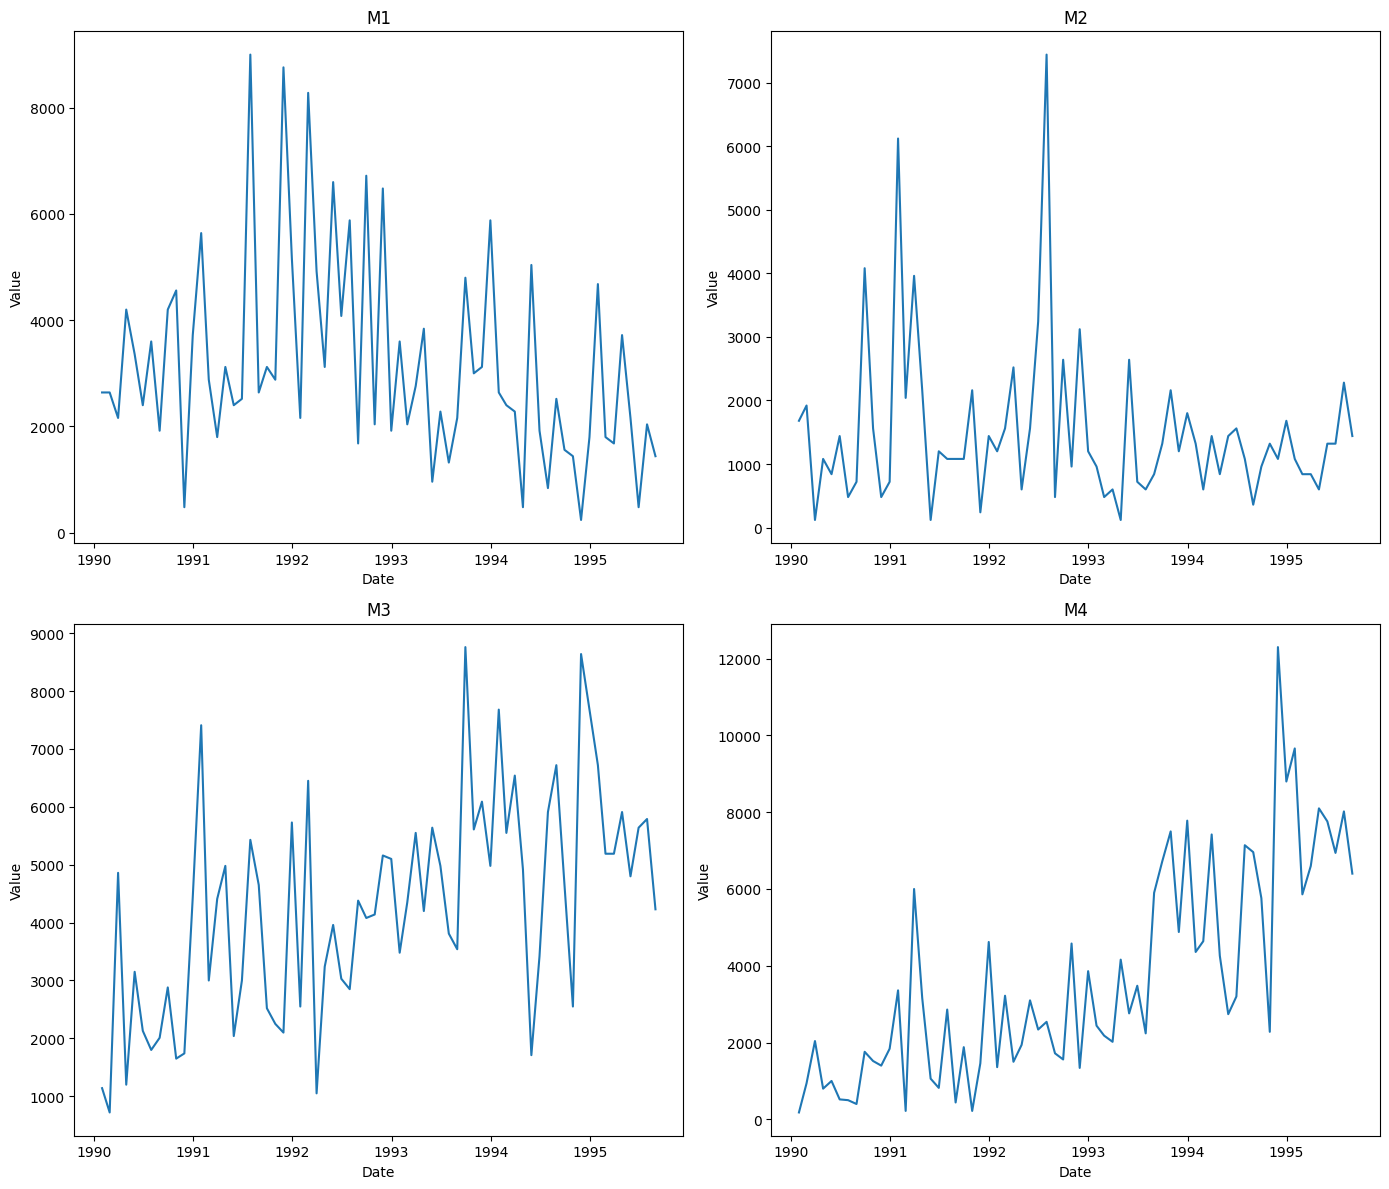

In [3]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,12))

for i, ax in enumerate(axes.flatten()):
    id = f"M{i+1}"
    filtered_df = Y_df[Y_df['unique_id'] == id]

    ax.plot(filtered_df['ds'], filtered_df['y'])
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.set_title(f"M{i+1}")

plt.tight_layout()

plt.savefig('figures/CH02_F03_peixeiro.png', dpi=300)

## Train model

In [4]:
from neuralforecast.core import NeuralForecast
from neuralforecast.models import NBEATS

horizon = 12

models = [
    NBEATS(
        input_size=2*horizon,
        h=horizon,
        max_steps=1000)
]

INFO:lightning_fabric.utilities.seed:Seed set to 1


In [5]:
nf = NeuralForecast(models=models, freq='M')
nf.fit(df=Y_df)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MAE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 2.4 M 
-----------------------------------------------
2.4 M     Trainable params
900       Non-trainable params
2.4 M     Total params
9.789     Total estimated model params size (MB)


Epoch 2:  22%|███▌            | 10/45 [00:00<00:03, 10.83it/s, v_num=18, train_loss_step=869.0, train_loss_epoch=578.0]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 4:  44%|███████         | 20/45 [00:01<00:02, 10.83it/s, v_num=18, train_loss_step=486.0, train_loss_epoch=547.0]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 6:  67%|██████████▋     | 30/45 [00:02<00:01, 10.96it/s, v_num=18, train_loss_step=556.0, train_loss_epoch=544.0]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 8:  89%|██████████████▏ | 40/45 [00:03<00:00, 10.84it/s, v_num=18, train_loss_step=501.0, train_loss_epoch=534.0]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 11:  11%|█▊              | 5/45 [0

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 22:  22%|███▎           | 10/45 [00:01<00:04,  8.16it/s, v_num=18, train_loss_step=400.0, train_loss_epoch=553.0]


### Save model

In [6]:
nf.save(path='./model', 
        model_index=None, 
        overwrite=True, 
        save_dataset=False)

### Load model

In [7]:
pretrained_model = NeuralForecast.load(path='./model')

INFO:lightning_fabric.utilities.seed:Seed set to 1


## Transfer learning
### Load data

In [3]:
df = pd.read_csv('../data/AusAntidiabeticDrug.csv')
df['ds'] = pd.to_datetime(df['ds'])
df['ds'] = df['ds'] + pd.offsets.MonthEnd(0)
df.insert(0, 'unique_id', 1)

df.head()

,unique_id,ds,y
0,1,1991-07-31,3.526591
1,1,1991-08-31,3.180891
2,1,1991-09-30,3.252221
3,1,1991-10-31,3.611003
4,1,1991-11-30,3.565869


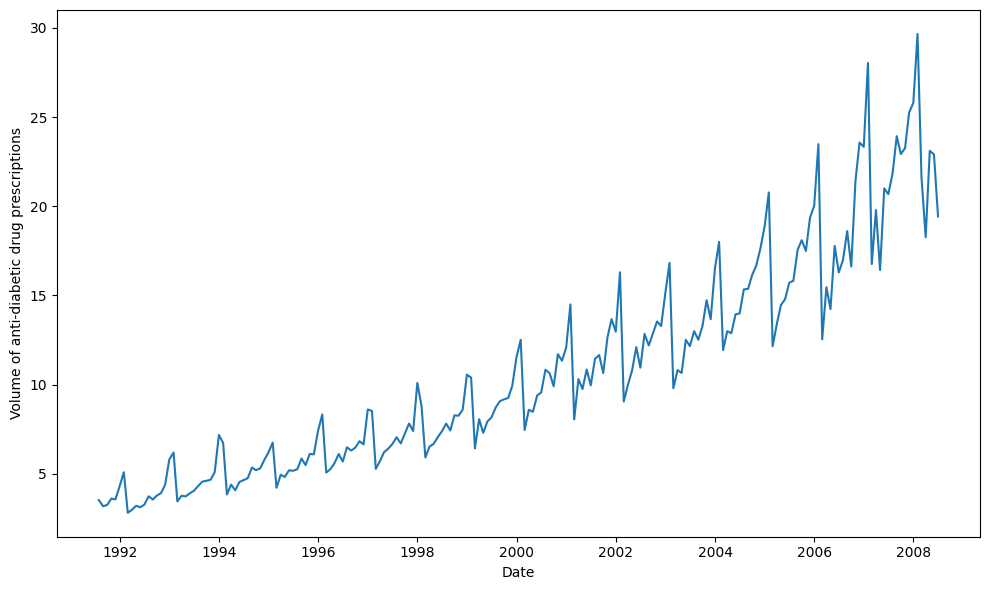

In [9]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(df['ds'], df['y'])
ax.set_xlabel('Date')
ax.set_ylabel('Volume of anti-diabetic drug prescriptions')

plt.tight_layout()

plt.savefig('figures/CH02_F02_peixeiro.png', dpi=300)

In [10]:
input_df = df[:-12]
test_df = df[-12:]

### Zero-shot forecasting

In [11]:
zero_shot_preds = pretrained_model.predict(input_df)
zero_shot_preds.head()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 201.62it/s]


,ds,NBEATS
unique_id,,
1,2007-07-31,20.580072
1,2007-08-31,22.462624
1,2007-09-30,22.215799
1,2007-10-31,24.778206
1,2007-11-30,25.082096


### Fine-tuning

In [12]:
def set_max_steps(nf, max_steps):
    trainer_kwargs = {**{"max_steps": max_steps}}
    nf.models[0].trainer_kwargs = trainer_kwargs

set_max_steps(pretrained_model, 10)

In [ ]:
pretrained_model.fit(input_df)

In [14]:
finetuned_preds = pretrained_model.predict()
finetuned_preds.head()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 199.99it/s]


,ds,NBEATS
unique_id,,
1,2007-07-31,21.491753
1,2007-08-31,23.564617
1,2007-09-30,19.293583
1,2007-10-31,24.422153
1,2007-11-30,25.840738


### Data-specific model

In [ ]:
models = [NBEATS(input_size=2*horizon, h=horizon, max_steps=100)]

nf = NeuralForecast(models=models, freq='M')
nf.fit(df=input_df)

In [16]:
trained_preds = nf.predict()
trained_preds.head()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 166.63it/s]


,ds,NBEATS
unique_id,,
1,2007-07-31,21.823566
1,2007-08-31,22.915501
1,2007-09-30,22.041903
1,2007-10-31,24.988390
1,2007-11-30,26.249281


## Evaluation

In [17]:
zero_shot_preds = zero_shot_preds.rename(columns={"NBEATS": "NBEATS_pretrained"})
finetuned_preds = finetuned_preds.rename(columns={"NBEATS": "NBEATS_finetuned"})
trained_preds = trained_preds.rename(columns={"NBEATS": "NBEATS_trained"})

test_df = pd.merge(test_df, zero_shot_preds, 'left', 'ds')
test_df = pd.merge(test_df, finetuned_preds, 'left', 'ds')
test_df = pd.merge(test_df, trained_preds, 'left', 'ds')

test_df.head()

,unique_id,ds,y,NBEATS_pretrained,NBEATS_finetuned,NBEATS_trained
0,1,2007-07-31,21.834890,20.580072,21.491753,21.823566
1,1,2007-08-31,23.930204,22.462624,23.564617,22.915501
2,1,2007-09-30,22.930357,22.215799,19.293583,22.041903
3,1,2007-10-31,23.263340,24.778206,24.422153,24.988390
4,1,2007-11-30,25.250030,25.082096,25.840738,26.249281


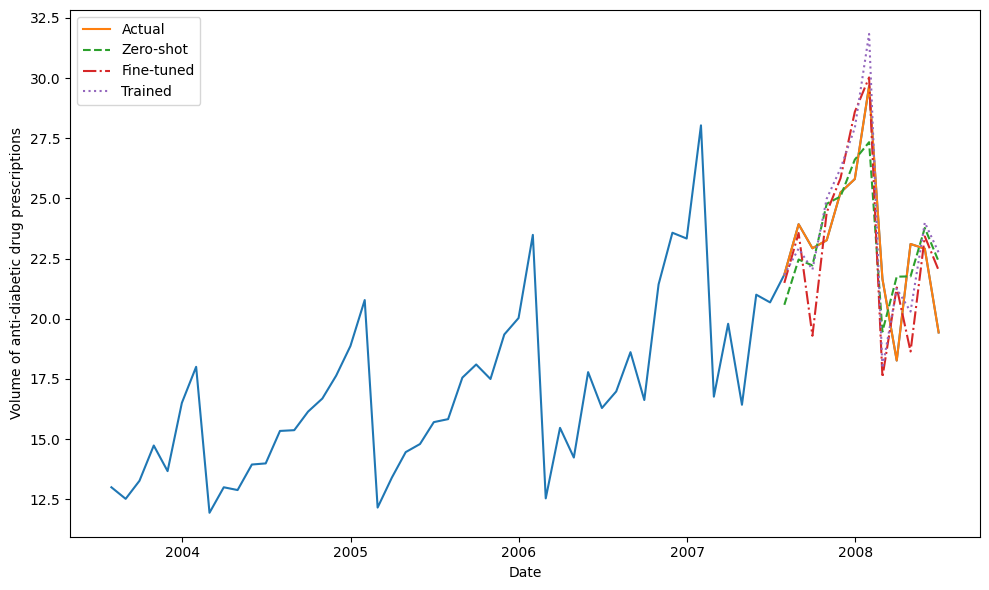

In [18]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(df['ds'].iloc[-60:], df['y'].iloc[-60:])
ax.plot(test_df['ds'], test_df['y'], label='Actual')
ax.plot(test_df['ds'], test_df['NBEATS_pretrained'], ls='--', label='Zero-shot')
ax.plot(test_df['ds'], test_df['NBEATS_finetuned'], ls='-.', label='Fine-tuned')
ax.plot(test_df['ds'], test_df['NBEATS_trained'], ls=':', label='Trained')

ax.set_xlabel('Date')
ax.set_ylabel('Volume of anti-diabetic drug prescriptions')

ax.legend(loc='best')

plt.tight_layout()

plt.savefig('figures/CH02_F03_peixeiro.png', dpi=300)

In [19]:
from utilsforecast.losses import mae, smape
from utilsforecast.evaluation import evaluate

evaluation = evaluate(
    test_df,
    metrics=[mae, smape],
    models=["NBEATS_pretrained", "NBEATS_finetuned", "NBEATS_trained"],
    target_col="y",
)

evaluation = evaluation.drop(['unique_id'], axis=1)
evaluation = evaluation.set_index('metric')
evaluation

,NBEATS_pretrained,NBEATS_finetuned,NBEATS_trained
metric,,,
mae,1.590311,1.994141,1.903190
smape,0.035618,0.046347,0.042274


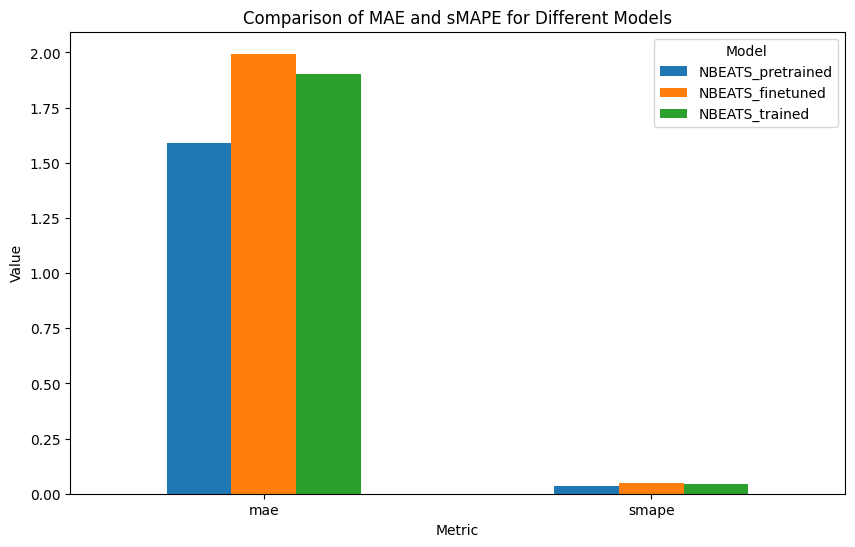

In [20]:
ax = evaluation.plot(kind='bar', figsize=(10, 6), rot=0)

# Adding labels and title
plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('Comparison of MAE and sMAPE for Different Models')
plt.legend(title='Model')

# Show plot
plt.show()

## Forecasting another frequency

In [75]:
daily_df = pd.read_csv('../data/daily_min_temp.csv')
daily_df = daily_df.rename(columns={"Date": "ds", "Temp": "y"})
daily_df['ds'] = pd.to_datetime(daily_df['ds'])
daily_df.insert(0, 'unique_id', 1)

daily_df.head()

,unique_id,ds,y
0,1,1981-01-01,20.7
1,1,1981-01-02,17.9
2,1,1981-01-03,18.8
3,1,1981-01-04,14.6
4,1,1981-01-05,15.8


In [76]:
d_input_df = daily_df[:-12]
d_test_df = daily_df[-12:]

### Zero-shot forecasting

In [77]:
pretrained_model = NeuralForecast.load(path='./model')

d_zero_shot_preds = pretrained_model.predict(d_input_df)
d_zero_shot_preds.head()

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 125.02it/s]


,ds,NBEATS
unique_id,,
1,1981-12-31,15.576023
1,1982-01-31,16.021452
1,1982-02-28,16.849257
1,1982-03-31,17.739635
1,1982-04-30,17.888920


### Training a model

In [78]:
models = [NBEATS(input_size=2*horizon, h=horizon, max_steps=500)]

nf = NeuralForecast(models=models, freq='D')
nf.fit(df=d_input_df)

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MAE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 2.4 M 
-----------------------------------------------
2.4 M     Trainable params
900       Non-trainable params
2.4 M     Total params
9.789     Total estimated model params size (MB)


Epoch 99: 100%|█████████████████| 1/1 [00:00<00:00, 10.87it/s, v_num=43, train_loss_step=0.751, train_loss_epoch=0.753]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|████████████████| 1/1 [00:00<00:00, 10.75it/s, v_num=43, train_loss_step=0.148, train_loss_epoch=0.150]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|████████████████| 1/1 [00:00<00:00, 10.64it/s, v_num=43, train_loss_step=0.118, train_loss_epoch=0.116]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████████| 1/1 [00:00<00:00, 10.87it/s, v_num=43, train_loss_step=0.0605, train_loss_epoch=0.0797]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████████| 1/1 [00:

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.


Epoch 499: 100%|██████████████| 1/1 [00:00<00:00,  8.55it/s, v_num=43, train_loss_step=0.0371, train_loss_epoch=0.0371]


In [79]:
d_trained_preds = nf.predict()
d_trained_preds.head()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 200.00it/s]


,ds,NBEATS
unique_id,,
1,1981-12-20,14.199825
1,1981-12-21,11.958052
1,1981-12-22,12.561469
1,1981-12-23,13.011676
1,1981-12-24,13.200665


### Evaluation

In [80]:
d_zero_shot_preds = d_zero_shot_preds.rename(columns={"NBEATS": "NBEATS_zero_shot"})
d_zero_shot_preds = d_zero_shot_preds.reset_index(drop=True)
d_trained_preds = d_trained_preds.rename(columns={"NBEATS": "NBEATS_trained"})

d_test_df = pd.merge(d_test_df, d_trained_preds, 'left', 'ds')
d_test_df = pd.concat([d_test_df, d_zero_shot_preds['NBEATS_zero_shot']], axis=1)

d_test_df.head()

,unique_id,ds,y,NBEATS_trained,NBEATS_zero_shot
0,1,1981-12-20,11.0,14.199825,15.576023
1,1,1981-12-21,11.1,11.958052,16.021452
2,1,1981-12-22,15.0,12.561469,16.849257
3,1,1981-12-23,12.8,13.011676,17.739635
4,1,1981-12-24,15.0,13.200665,17.888920


In [81]:
d_test_df

,unique_id,ds,y,NBEATS_trained,NBEATS_zero_shot
0,1,1981-12-20,11.0,14.199825,15.576023
1,1,1981-12-21,11.1,11.958052,16.021452
2,1,1981-12-22,15.0,12.561469,16.849257
3,1,1981-12-23,12.8,13.011676,17.739635
4,1,1981-12-24,15.0,13.200665,17.888920
5,1,1981-12-25,14.2,15.099745,15.102144
6,1,1981-12-26,14.0,15.331948,16.676064
7,1,1981-12-27,15.5,12.973417,16.231840
8,1,1981-12-28,13.3,13.070344,15.966508
9,1,1981-12-29,15.6,13.450594,17.462860


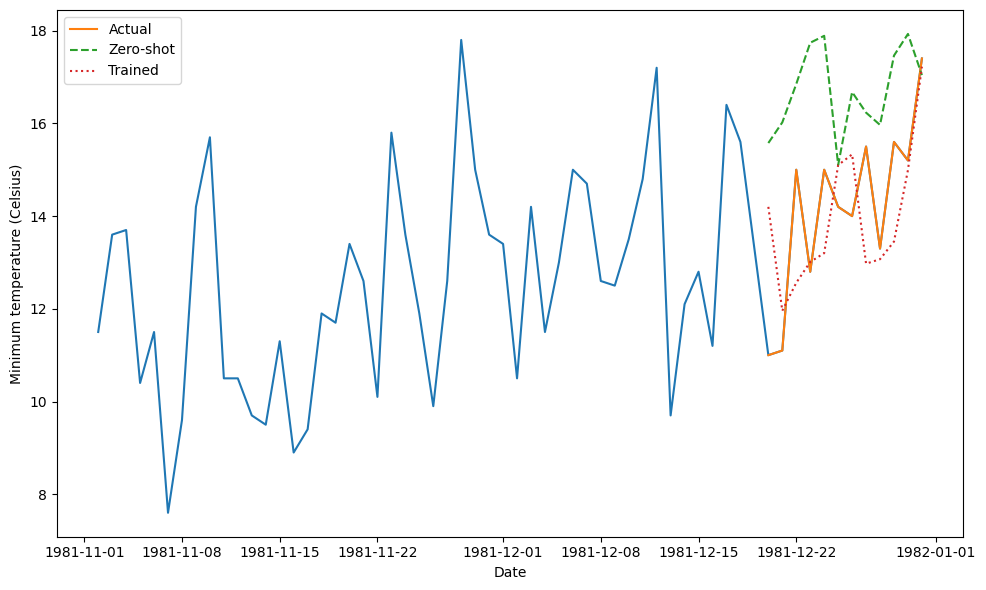

In [82]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(daily_df['ds'].iloc[-60:], daily_df['y'].iloc[-60:])
ax.plot(d_test_df['ds'], d_test_df['y'], label='Actual')
ax.plot(d_test_df['ds'], d_test_df['NBEATS_zero_shot'], ls='--', label='Zero-shot')
ax.plot(d_test_df['ds'], d_test_df['NBEATS_trained'], ls=':', label='Trained')

ax.set_xlabel('Date')
ax.set_ylabel("Minimum temperature (Celsius)")

ax.legend(loc='best')

plt.tight_layout()

plt.savefig('figures/CH02_F04_peixeiro.png', dpi=300)

In [83]:
d_evaluation = evaluate(
    d_test_df,
    metrics=[mae, smape],
    models=["NBEATS_zero_shot", "NBEATS_trained"],
    target_col="y",
)

d_evaluation = d_evaluation.drop(['unique_id'], axis=1)
d_evaluation = d_evaluation.set_index('metric')
d_evaluation

,NBEATS_zero_shot,NBEATS_trained
metric,,
mae,2.591858,1.335655
smape,0.086885,0.048680
